# Tutorial 03: Running multiple simulations

In tutorials 1 and 2 we've seen how to initialize a simulation and run a single instance, and how to design an adversarial agent to degrade the traffic flow. In this tutorial we will look at setting up running a set of simulations, which allows us to vary different paremeters of interest.

First, let's re-import the quantities needed from Flow that we used in tutorial 1 to run a ring-road environment. These will be re-usable across different pieces of code we write subsequently.

In [5]:
#Import different needed quantities:
from flow.networks.ring import RingNetwork
from flow.core.params import VehicleParams
from flow.controllers.car_following_models import IDMController #Human driving model
from flow.controllers.routing_controllers import ContinuousRouter #Router that keeps vehicles on the ring-road
from flow.networks.ring import ADDITIONAL_NET_PARAMS
from flow.core.params import NetParams
from flow.core.params import InitialConfig
from flow.core.params import TrafficLightParams
from flow.envs.ring.accel import AccelEnv
from flow.envs.ring.accel import ADDITIONAL_ENV_PARAMS
from flow.core.params import SumoParams
from flow.core.params import EnvParams
from flow.core.experiment import Experiment

print('Imports succesful.')

Imports succesful.


Next, let's take the code that we used to instantiate and run a simulation, but wrap it inside of a function this time. Additionally, let's pass an argument to the function which sets the length of the ring to a custom value:

In [27]:
def run_ring_sim_no_attack(ring_length):
    #Simulation parameters:
    time_step = 0.1 #In seconds, how far each step of the simulation goes.
    emission_path = 'data' #Where
    want_render = False #If we want SUMO to render the environment and display the simulation.
    sim_horizon = 5000 #How many simulation steps will be taken -> Runs for 300 seconds

    #initialize the simulation using above parameters:
    traffic_lights = TrafficLightParams() #This is empty, so no traffic lights are used.
    initial_config = InitialConfig(spacing="uniform", perturbation=1) #Vehicles start out evenly spaced.
    vehicles = VehicleParams() #The vehicles object will store different classes of drivers:
    sim_params = SumoParams(sim_step=time_step, render=want_render, emission_path=emission_path) #Sets the simulation time-step and where data will be recorded.
    env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS)
    net_params = NetParams(additional_params={'length':ring_length,
                                              'lanes':1,
                                              'speed_limit': 30,
                                              'resolution': 40})

    #Specify how human driven vehicles will drive:
    num_human_drivers = 20
    # Define a driver model human drivers:
    vehicles.add("human",
                 acceleration_controller=(IDMController, {'noise':0.1}),
                 routing_controller=(ContinuousRouter, {}),
                 num_vehicles=num_human_drivers)


    #initialize the simulation:
    flow_params = dict(
        exp_tag='ring_no_attack',
        env_name=AccelEnv,
        network=RingNetwork,
        simulator='traci',
        sim=sim_params,
        env=env_params,
        net=net_params,
        veh=vehicles,
        initial=initial_config,
        tls=traffic_lights,
    )

    flow_params['env'].horizon = sim_horizon
    exp = Experiment(flow_params)
    print('Running ring simulation, ring length: '+str(ring_length))
    
    sim_res_list = exp.run(1, convert_to_csv=True)
    
    return sim_res_list

print('Simulation function defined.')


Simulation function defined.


Let's run a brief test to make sure it's working:

In [7]:
ring_length = 500
sim_res_list = run_ring_sim_no_attack(ring_length)

Running ring simulation, ring length: 500
Round 0, return: 1543.5124293802355
data/ring_no_attack_20211222-1837301640216250.8573399-0_emission.csv data
Average, std returns: 1543.5124293802355, 0.0
Average, std velocities: 16.694649748927223, 0.0
Average, std outflows: 0.0, 0.0
Total time: 35.85313010215759
steps/second: 173.65488150263565


[{'returns': [1543.5124293802355],
  'velocities': [16.694649748927223],
  'outflows': [0.0]},
 'data/ring_no_attack_20211222-1837301640216250.8573399-0_emission.csv']

run_ring_sim_no_attack(ring_length) runs a ring simulation using the IDM cfm with a custom ring_length and returns the simulation results, which includes the path to the data file generated. Let's write one more function to extract quantities of interest from a simulation.

In [ ]:
import os
import numpy as np
import flow.visualize.visualize_ring as visualize_ring

def get_sim_results(sim_res_list):
    emission_path = os.path.join(os.getcwd(),sim_res_list[1])
    timeseries_dict = visualize_ring.get_sim_timeseries(csv_path = emission_path)
    
    speeds = []
    fuel_consumptions = []
    for veh_id in timeseries_dict:
        speed = timeseries_dict[veh_id][:,1]
        fuel_consumption = timeseries_dict[veh_id][:,5]
        
        #Select the last half of the simulation:
        speeds.append(speed[3000:])
        fuel_consumptions.append(fuel_consumption[3000:])
        
    speeds = np.array(speeds)
    fuel_consumptions = np.array(fuel_consumptions)
    
    mean_speed = np.mean(speeds)
    std_speed = np.std(speeds)
    mean_fuel_consumption = np.mean(fuel_consumptions)
    
    return [mean_speed,std_speed,mean_fuel_consumption]

print('Simulation results function defined.')

Let's now look the affect that sweeping across different ring lengths will have on the different quantities of interest. Fair warning: On my Quad-Core Intel Core i5 MacBook this took 145.5 seconds to run.

In [28]:
import time

begin_compute_time = time.time()

ring_length_values = [300,400,500,600,700] #Different ring lengths
sim_res_values = [] #Where sim_res_list is stored
for ring_length in ring_length_values:
    sim_res_list = run_ring_sim_no_attack(ring_length)
    sim_res_values.append(sim_res_list)

# Get quantities of interest from each simulation:
ring_length_sim_sweep_results = []
for sim_res_list in sim_res_values:
    ring_length_sim_sweep_results.append(get_sim_results(sim_res_list))
ring_length_sim_sweep_results = np.array(ring_length_sim_sweep_results)

end_compute_time = time.time()
print('Total computation time: '+str(end_compute_time-begin_compute_time))



Running ring simulation, ring length: 300
Round 0, return: 4036.9678775874404
data/ring_no_attack_20211223-0931521640269912.4807732-0_emission.csv data
Average, std returns: 4036.9678775874404, 0.0
Average, std velocities: 8.309804851700001, 0.0
Average, std outflows: 0.0, 0.0
Total time: 26.46195125579834
steps/second: 216.73561287270445
Running ring simulation, ring length: 400
Round 0, return: 3427.882049880898
data/ring_no_attack_20211223-0932201640269940.0489159-0_emission.csv data
Average, std returns: 3427.882049880898, 0.0
Average, std velocities: 12.907723032053259, 0.0
Average, std outflows: 0.0, 0.0
Total time: 27.069471836090088
steps/second: 209.7329529751265
Running ring simulation, ring length: 500
Round 0, return: 1543.4732110376124
data/ring_no_attack_20211223-0932481640269968.2175229-0_emission.csv data
Average, std returns: 1543.4732110376124, 0.0
Average, std velocities: 16.694782812656165, 0.0
Average, std outflows: 0.0, 0.0
Total time: 26.942538022994995
steps/sec

Let's plot the results now to visualize:

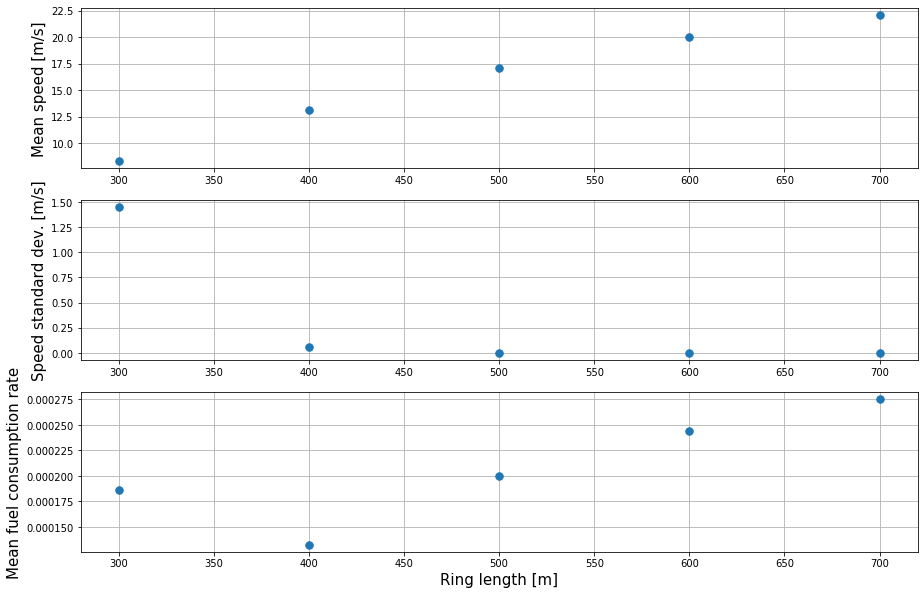

In [38]:
import matplotlib.pyplot as plt
fontsize=15
markersize=15

plt.figure(figsize=[15,10])
plt.subplot(3,1,1)
plt.plot(ring_length_values,ring_length_sim_sweep_results[:,0],'.',markersize=markersize)
plt.ylabel('Mean speed [m/s]',fontsize=fontsize)
plt.grid()
plt.subplot(3,1,2)
plt.plot(ring_length_values,ring_length_sim_sweep_results[:,1],'.',markersize=markersize)
plt.ylabel('Speed standard dev. [m/s]',fontsize=fontsize)
plt.grid()
plt.subplot(3,1,3)
plt.plot(ring_length_values,ring_length_sim_sweep_results[:,2],'.',markersize=markersize)
plt.ylabel('Mean fuel consumption rate',fontsize=fontsize)
plt.xlabel('Ring length [m]',fontsize=fontsize)
plt.grid()

In the context of Anti-Flow one of the most important pieces of analysis is understanding how different instances of an attack model can affect a traffic flow. Let's now look at the attack model introduced in tutorial_02. This controller had effectively 3 parameters: v_des, braking_rate, and braking_period. Let's investigate the effect that varying v_des has on the traffic flow.

First, we redefine the control model:

In [40]:
from Adversaries.controllers.base_controller import BaseController

class cfm_adversarial(BaseController):
    def __init__(self,
                 veh_id,
                 car_following_params,
                 delay=0.0,
                 noise=0.0,
                 fail_safe=None,
                 v_des=10.0,
                 braking_period = 5.0,
                 braking_rate = - 2.0):
        #Inherit the base controller:
        BaseController.__init__(
            self,
            veh_id,
            car_following_params,
            delay=delay,
            fail_safe=fail_safe,
            noise=noise)
        
        self.braking_period = braking_period #How long the mAV brakes for
        self.braking_rate = braking_rate #How hard the mAV brakes
        self.curr_braking_period = 0.0 #Keeps track of braking
        self.is_braking = False #Whether or not engaged in braking
        self.v_des = v_des #If not braking, what speed the mAV tries to drive at
                
    def get_accel(self, env):
        lead_id = env.k.vehicle.get_leader(self.veh_id) #Who is the leader
        v_l = env.k.vehicle.get_speed(lead_id) #Leader speed
        v = env.k.vehicle.get_speed(self.veh_id) #vehicle's own speed
        s = env.k.vehicle.get_headway(self.veh_id) #inter-vehicle spacing to leader
        u = 0.0
        
        #If the vehicle gets too close it brakes for a long period of time:
        if(s < 5.0):
            self.is_braking = True

        #Engaged in braking:    
        if(self.is_braking):
            u = self.braking_rate
            self.curr_braking_period += env.sim_step
            if(self.curr_braking_period>=self.braking_period):
                self.curr_braking_period = 0.0
                self.is_braking = False
                
        #Managing speed:
        else:
            u = 0.1*(self.v_des - v) #Simple proportional speed control
            
        return u #return the acceleration that is set above.
        
    def get_custom_accel(self, v, v_l, s):
        """Leave as 0.0 since behavior has memory"""
        return 0.0
    
    print('Adversarial AV initialized.')

Adversarial AV initialized.


Now let's define another simulation function which accepts the different attack model parameters as inputs:

In [46]:
def run_ring_sim_with_attack(ring_length=300,
                           v_des=10.0,
                           braking_period = 10.0,
                           braking_rate= -2.0):
    #Simulation parameters:
    time_step = 0.1 #In seconds, how far each step of the simulation goes.
    emission_path = 'data' #Where
    want_render = False #If we want SUMO to render the environment and display the simulation.
    sim_horizon = 5000 #How many simulation steps will be taken -> Runs for 300 seconds

    #initialize the simulation using above parameters:
    traffic_lights = TrafficLightParams() #This is empty, so no traffic lights are used.
    initial_config = InitialConfig(spacing="uniform", perturbation=1) #Vehicles start out evenly spaced.
    vehicles = VehicleParams() #The vehicles object will store different classes of drivers:
    sim_params = SumoParams(sim_step=time_step, render=want_render, emission_path=emission_path) #Sets the simulation time-step and where data will be recorded.
    env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS)
    net_params = NetParams(additional_params={'length':ring_length,
                                              'lanes':1,
                                              'speed_limit': 30,
                                              'resolution': 40})

    #Specify how human driven vehicles will drive:
    num_human_drivers = 19
    # Define a driver model human drivers:
    vehicles.add("human",
                 acceleration_controller=(IDMController, {'noise':0.1}),
                 routing_controller=(ContinuousRouter, {}),
                 num_vehicles=num_human_drivers)
    
    vehicles.add(veh_id="Adv_AV",
             color="red", #Let's make the adversary red
             acceleration_controller=(cfm_adversarial, {'v_des':v_des,
                                                        'braking_rate':braking_rate,
                                                        'braking_period':braking_period}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=1)

    #initialize the simulation:
    flow_params = dict(
        exp_tag='ring_with_attack',
        env_name=AccelEnv,
        network=RingNetwork,
        simulator='traci',
        sim=sim_params,
        env=env_params,
        net=net_params,
        veh=vehicles,
        initial=initial_config,
        tls=traffic_lights,
    )

    flow_params['env'].horizon = sim_horizon
    exp = Experiment(flow_params)
    print('Running ring attack, v_des: '+str(v_des))
    
    sim_res_list = exp.run(1, convert_to_csv=True)
    
    return sim_res_list

print('Attack Simulation function defined.')

Attack Simulation function defined.


Let's specifically look at varying v_des:

In [44]:
begin_compute_time = time.time()

v_des_vals = [1.0,3.0,5.0,7.0,9.0,11.0] #Different ring lengths
sim_res_values = [] #Where sim_res_list is stored
for v_des in v_des_vals:
    sim_res_list = run_ring_sim_with_attack(v_des=v_des)
    sim_res_values.append(sim_res_list)

# Get quantities of interest from each simulation:
ring_attack_sim_sweep_results = []
for sim_res_list in sim_res_values:
    ring_attack_sim_sweep_results.append(get_sim_results(sim_res_list))
ring_attack_sim_sweep_results = np.array(ring_attack_sim_sweep_results)

end_compute_time = time.time()
print('Total computation time: '+str(end_compute_time-begin_compute_time))


Running ring simulation, ring length: 300
Round 0, return: 567.9537677166932
data/ring_with_attack_20211223-1203231640279003.9762912-0_emission.csv data
Average, std returns: 567.9537677166932, 0.0
Average, std velocities: 1.1594783893568288, 0.0
Average, std outflows: 0.0, 0.0
Total time: 21.585878133773804
steps/second: 265.45936635257766
Running ring simulation, ring length: 300
Round 0, return: 1534.4568316301418
data/ring_with_attack_20211223-1203461640279026.730783-0_emission.csv data
Average, std returns: 1534.4568316301418, 0.0
Average, std velocities: 3.087095096427138, 0.0
Average, std outflows: 0.0, 0.0
Total time: 22.75223398208618
steps/second: 249.05286249625198
Running ring simulation, ring length: 300
Round 0, return: 2495.071804627135
data/ring_with_attack_20211223-1204101640279050.5781991-0_emission.csv data
Average, std returns: 2495.071804627135, 0.0
Average, std velocities: 5.003441256280003, 0.0
Average, std outflows: 0.0, 0.0
Total time: 23.853082180023193
steps/

Again, we can visualize the results of the parameter sweep:

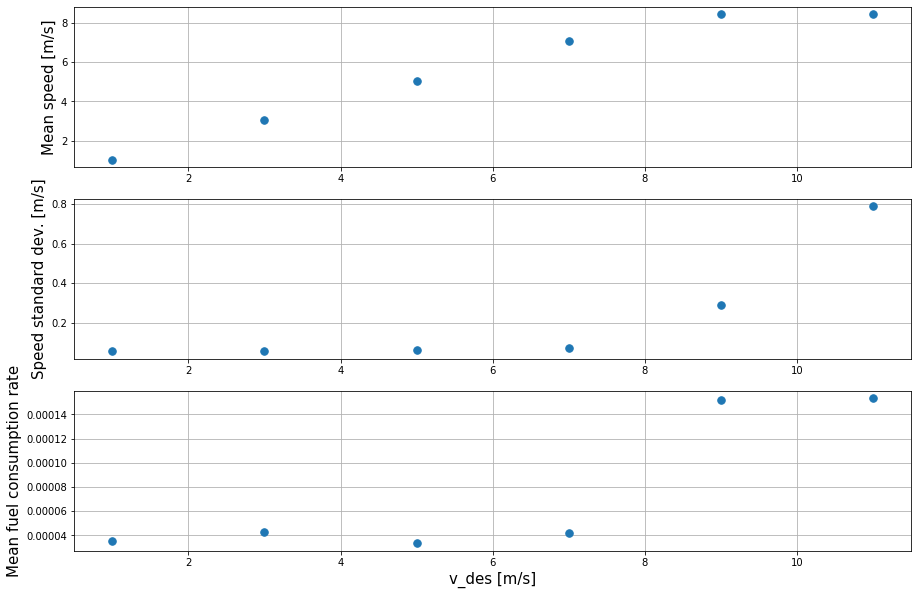

In [48]:
import matplotlib.pyplot as plt
fontsize=15
markersize=15

plt.figure(figsize=[15,10])
plt.subplot(3,1,1)
plt.plot(v_des_vals,ring_attack_sim_sweep_results[:,0],'.',markersize=markersize)
plt.ylabel('Mean speed [m/s]',fontsize=fontsize)
plt.grid()
plt.subplot(3,1,2)
plt.plot(v_des_vals,ring_attack_sim_sweep_results[:,1],'.',markersize=markersize)
plt.ylabel('Speed standard dev. [m/s]',fontsize=fontsize)
plt.grid()
plt.subplot(3,1,3)
plt.plot(v_des_vals,ring_attack_sim_sweep_results[:,2],'.',markersize=markersize)
plt.ylabel('Mean fuel consumption rate',fontsize=fontsize)
plt.xlabel('v_des [m/s]',fontsize=fontsize)
plt.grid()

It's interesting to note that depending on what criteria the attacking agent is most interested in, different choices of v_des migth be more or less desirable.

## General advice:

Any given traffic simulation in Anti-Flow may have tens to hundreds of different parameters that could be varied/explored, however many may not change the simulation results much if changed. We recommend when trying to explore a traffic environment to try and isolate the set of parameters which are of most significance, or which might vary the most in a real world environment, rather than trying to sweep across all possible model parameter sets. 

As simulations grow in time and the number of vehicles on the network, so to will the size of simulation data files. Be warned that for sufficiently large simulations memory may become a legitimate issue.